In [1]:
# grader-required-cell

import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [74]:
import os
import cv2
import numpy as np

def parse_data_from_input(dataset_dir):
    # Define the path to your dataset directory containing subdirectories for each class

    # Initialize empty lists to store images and labels
    images = []
    labels = []

    # Create a list of class labels based on subdirectory names
    class_labels = os.listdir(dataset_dir)

    # Loop through each subdirectory (class)
    for label, class_name in enumerate(class_labels):
        class_dir = os.path.join(dataset_dir, class_name)
        count = 1 
        # Loop through all files in the class directory
        for filename in os.listdir(class_dir):
            if filename.endswith((".jpg", ".png")):  # Adjust file extensions as needed
                new_path = os.path.join(class_dir, filename)
                 # Specify the old and new file names
                # Generate a unique filename by adding a count to the original filename
#                 base_filename, file_extension = os.path.splitext(filename)
#                 new_filename = f"{class_name}_{count}{file_extension}"
#                 new_path = os.path.join(class_dir, new_filename)
                
                # Increment the count to ensure the next file has a unique name
                count += 1

                # Rename the file
#                 os.rename(file_path, new_path)
                # Load the image using OpenCV
                image = cv2.imread(new_path)
                # If you want to save the grayscale image to a file
                cv2.imwrite(new_path, image)

                # Resize the image to a consistent size if needed
                image = cv2.resize(image, (224, 224))

                # Append the image and its corresponding label to the lists
                images.append(image)
                labels.append(label)

    # Convert the lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

    # You can then use 'images' and 'labels' in your machine learning model

In [75]:
TRAINING_FILE = r'train'
VALIDATION_FILE = r'test'

In [76]:
# grader-required-cell

# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (4682, 224, 224, 3) and dtype: uint8
Training labels has shape: (4682,) and dtype: int32
Validation images has shape: (355, 224, 224, 3) and dtype: uint8
Validation labels has shape: (355,) and dtype: int32


In [77]:
print(training_labels[1500])

1


In [78]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # In this section you will have to add another dimension to the data
  # So, for example, if your array is (10000, 28, 28)
  # You will need to make it (10000, 28, 28, 1)
  # Hint: np.expand_dims
#   training_images = np.expand_dims(training_images, axis = -2)
#   validation_images = np.expand_dims(validation_images, axis = -2)

  # Instantiate the ImageDataGenerator class
  # Don't forget to normalize pixel values
  # and set arguments to augment the images (if desired)
  train_datagen = ImageDataGenerator(
      rescale = 1./255.,
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
      horizontal_flip=True
#       fill_mode='nearest'
      )


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=16,
)


  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=16)

  ### END CODE HERE

  return train_generator, validation_generator

In [79]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (4682, 224, 224, 3)
Labels of training generator have shape: (4682,)
Images of validation generator have shape: (355, 224, 224, 3)
Labels of validation generator have shape: (355,)


In [80]:
def create_model():

  ### START CODE HERE

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),   
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      # 5 classes
      tf.keras.layers.Dense(4, activation='softmax')
  ])


  model.compile(optimizer = tf.optimizers.Adam(),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  ### END CODE HERE

  return model

In [81]:
# Save your model
model = create_model()

# Train your model
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator)


Epoch 1/30
293/293 [==============================] - 86s 286ms/step - loss: 0.3125 - accuracy: 0.8746 - val_loss: 0.1542 - val_accuracy: 0.9690
Epoch 2/30
293/293 [==============================] - 83s 284ms/step - loss: 0.0788 - accuracy: 0.9752 - val_loss: 0.0445 - val_accuracy: 0.9775
Epoch 3/30
293/293 [==============================] - 87s 296ms/step - loss: 0.0812 - accuracy: 0.9731 - val_loss: 0.0638 - val_accuracy: 0.9746
Epoch 4/30
293/293 [==============================] - 86s 295ms/step - loss: 0.0453 - accuracy: 0.9842 - val_loss: 0.1253 - val_accuracy: 0.9493
Epoch 5/30
293/293 [==============================] - 85s 291ms/step - loss: 0.0245 - accuracy: 0.9930 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 6/30
293/293 [==============================] - 84s 286ms/step - loss: 0.0220 - accuracy: 0.9934 - val_loss: 0.0565 - val_accuracy: 0.9831
Epoch 7/30
293/293 [==============================] - 80s 273ms/step - loss: 0.0172 - accuracy: 0.9953 - val_loss: 0.0092 - val_ac

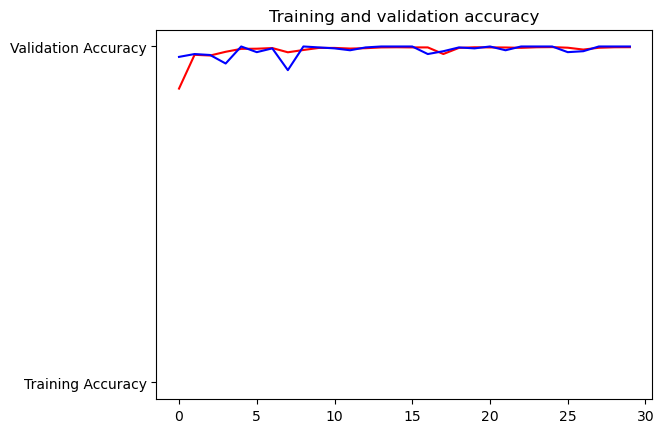

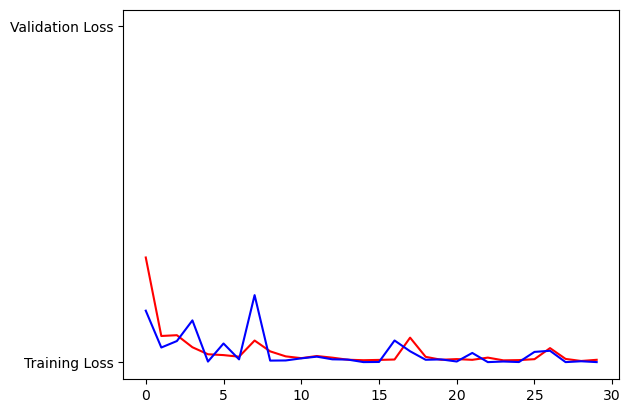

In [82]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [2]:
# # Load the model
from keras.models import load_model  # TensorFlow is required for Keras to work
import cv2  # Install opencv-python
import numpy as np
model = load_model("Capstone Project_WOAI_model.h5", compile=False)

In [3]:

## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

 
  # predicting images
path=r'test\Down-Correct\23262_png.rf.229b39ed42db55a32c912dd529b9fd1d.jpg'
img=load_img(path, target_size=(224, 224))
  
x=img_to_array(img)
x /= 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=16)
print("Down-Correct")  
print(classes)


1/1 [==============================] - 1s 580ms/step
Down-Correct
[[1.0000000e+00 5.4922924e-16 1.7108101e-10 3.0147921e-15]]


In [4]:

## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

 
  # predicting images
path=r'test\Down-Wrong\6_380 - Copy.jpg'
img=load_img(path, target_size=(224, 224))
  
x=img_to_array(img)
x /= 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=16)
print("Down-Wrong")  
print(classes)


1/1 [==============================] - 0s 50ms/step
Down-Wrong
[[1.0774982e-05 9.8621446e-01 1.3147669e-02 6.2714593e-04]]


In [5]:

## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

 
  # predicting images
path=r'test\Up-Correct\6068_png.rf.31490652a258e3f4f98e89015b326a31.jpg'
img=load_img(path, target_size=(224, 224))
  
x=img_to_array(img)
x /= 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=16)
print("Up-Correct")   
print(classes[0])


1/1 [==============================] - 0s 48ms/step
Up-Correct
[8.6999796e-11 1.0009071e-10 1.0000000e+00 7.0148256e-09]


In [8]:

## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

 
  # predicting images
path=r'train\Up-Wrong\image4_324.jpg'
img=load_img(path, target_size=(224, 224))
  
x=img_to_array(img)
x /= 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=16)
print("Up-Wrong")  
print(classes[0])


1/1 [==============================] - 0s 46ms/step
Up-Wrong
[1.8447554e-15 5.7340008e-09 9.4839323e-01 5.1606856e-02]


In [103]:
# import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2
# model.save('Capstone Project_WOAI_model.h5')

In [117]:
# # Load the model
# model = load_model("keras_model.h5", compile=False)

# # Load the labels
# class_names = open("labels.txt", "r").readlines()

In [108]:
from keras.models import load_model  # TensorFlow is required for Keras to work
import cv2  # Install opencv-python
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

path=r'test\Down-Correct\23582_png.rf.1a158f848bed2560853e56c1fee9d0e5.jpg'
image=load_img(path, target_size=(224, 224))

image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)

# Normalize the image array
image = (image / 127.5) - 1

# Predicts the model
prediction = model.predict(image)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")


1/1 [==============================] - 1s 1s/step
Class: Down-Correct
Confidence Score: 100 %


In [73]:
from keras.models import load_model  # TensorFlow is required for Keras to work
import cv2  # Install opencv-python
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

path=r'test\Down-Wrong\image2_432.jpg'
image=load_img(path, target_size=(224, 224))

image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)

# Normalize the image array
image = (image / 127.5) - 1

# Predicts the model
prediction = model.predict(image)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")


1/1 [==============================] - 1s 1s/step
Class: Down-Wrong
Confidence Score: 100 %


In [70]:
from keras.models import load_model  # TensorFlow is required for Keras to work
import cv2  # Install opencv-python
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

path=r'test\Up-Correct\6068_png.rf.31490652a258e3f4f98e89015b326a31.jpg'
image=load_img(path, target_size=(224, 224))

image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)

# Normalize the image array
image = (image / 127.5) - 1

# Predicts the model
prediction = model.predict(image)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")


1/1 [==============================] - 1s 1s/step
Class: Up-Correct
Confidence Score: 100 %


In [71]:
from keras.models import load_model  # TensorFlow is required for Keras to work
import cv2  # Install opencv-python
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

path=r'test\Up-Wrong\image8_882.jpg'
image=load_img(path, target_size=(224, 224))

image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)

# Normalize the image array
image = (image / 127.5) - 1

# Predicts the model
prediction = model.predict(image)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")


1/1 [==============================] - 1s 1s/step
Class: Up-Wrong
Confidence Score: 100 %
